In [1]:
# Cell 1 - setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from pathlib import Path


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1200)
sns.set(style='whitegrid')

In [2]:
# Cell 2 - Load Excel file
xlsx_path = Path("/Users/neelbardhan/Desktop/Capstone/Online Retail.xlsx")
if not xlsx_path.exists():
    raise FileNotFoundError(f"File not found: {xlsx_path}. Fix the path and re-run.")

# read first sheet (standard dataset)
df_raw = pd.read_excel(xlsx_path, sheet_name=0, engine="openpyxl")
print("Loaded shape:", df_raw.shape)
display(df_raw.head())

Loaded shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


*This is the data loading and package imports.*

In [3]:
# Cell 3 - Diagnostics
print("Columns:", df_raw.columns.tolist())
print("\nBasic info:")
display(df_raw.info())

print("\nMissing counts (top):")
display(df_raw.isna().sum().sort_values(ascending=False).head(10))

print("\nSample unique customers:", df_raw['CustomerID'].nunique(), "unique CustomerIDs")
print("Sample countries:", df_raw['Country'].nunique())

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


None


Missing counts (top):


CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64


Sample unique customers: 4372 unique CustomerIDs
Sample countries: 38


In [4]:
# Cell 4 - Cleaning and basic feature engineering
df = df_raw.copy()

# Standardize column names if needed
df.columns = [c.strip() for c in df.columns]

# Coerce InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Drop rows without InvoiceDate (if any)
df = df.dropna(subset=['InvoiceDate'])

# Remove transactions with missing CustomerID for customer-based segmentation
df = df.dropna(subset=['CustomerID'])

# Remove cancelled / refund rows where InvoiceNo starts with 'C' or Quantity <= 0
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]

# Create TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert CustomerID to int (it may be float due to NaNs earlier)
df['CustomerID'] = df['CustomerID'].astype(int)

print("Cleaned shape:", df.shape)
display(df.head())

Cleaned shape: (397924, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


Text(0.5, 1.0, 'Top 8 Countries by Transactions')

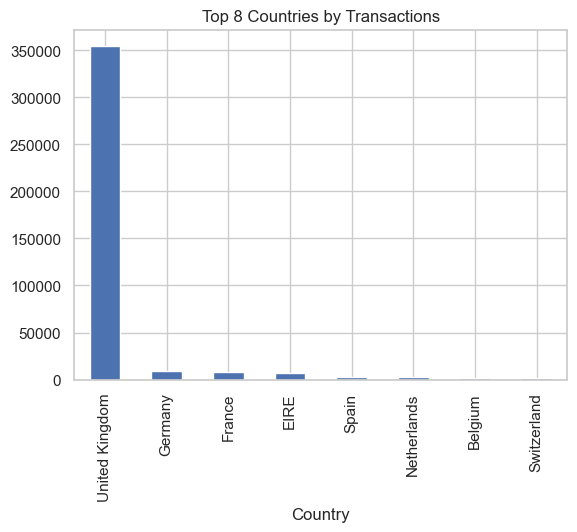

In [5]:
# Cell 5 - EDA plots
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
df['Country'].value_counts().nlargest(8).plot(kind='bar')
plt.title('Top 8 Countries by Transactions')

# plt.subplot(2,2,2)
# sns.histplot(df['Quantity'], bins=50, log_scale=(False, True))
# plt.title('Quantity distribution (log scale y)')

# plt.subplot(2,2,3)
# sns.histplot(df['UnitPrice'], bins=50, log_scale=(False, True))
# plt.title('UnitPrice distribution (log scale y)')

# plt.subplot(2,2,4)
# df['TotalPrice'].describe().to_frame().T
# plt.text(0.1, 0.5, df['TotalPrice'].describe().to_string(), family='monospace')
# plt.axis('off')
# plt.title('TotalPrice summary')

# plt.tight_layout()
# plt.savefig("eda_overview.png", dpi=150)
# plt.show()

In [6]:
# Cell 6 - RFM computation
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Inspect RFM
rfm = rfm.sort_values('Monetary', ascending=False)
display(rfm.head())
print("RFM shape:", rfm.shape)

,Recency,Frequency,Monetary
CustomerID,,,
14646,2,74,280206.02
18102,1,60,259657.30
17450,8,46,194550.79
16446,1,2,168472.50
14911,1,201,143825.06


RFM shape: (4339, 3)


RFM is a classic customer-analytics framework used in marketing and CRM. It breaks customer behavior into three simple dimensions that predict how likely someone is to buy again.

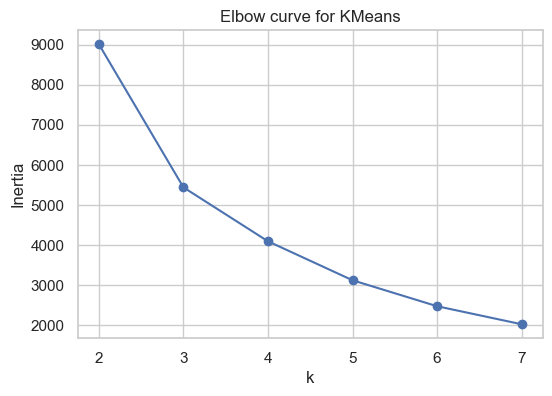

,Recency,Frequency,Monetary
0,43.86,3.68,1358.04
1,15.50,22.33,12709.09
2,7.38,82.69,127338.31
3,248.56,1.55,478.11


In [7]:
# Cell 7 - Scale RFM and choose k
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

# elbow method (quick)
inertia = []
K_range = range(2,8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, '-o')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Elbow curve for KMeans')
plt.grid(True)
plt.savefig("kmeans_elbow.png", dpi=150)
plt.show()

# pick k = 4 (reasonable default) — you can change if elbow suggests otherwise
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# cluster centers (inverse transform to original scale)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=['Recency','Frequency','Monetary']).round(2)
display(centers_df)

Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0         43.82      3.68    1357.52  3059
1         15.50     22.33   12709.09   204
2          7.38     82.69  127338.31    13
3        248.47      1.55     480.42  1063

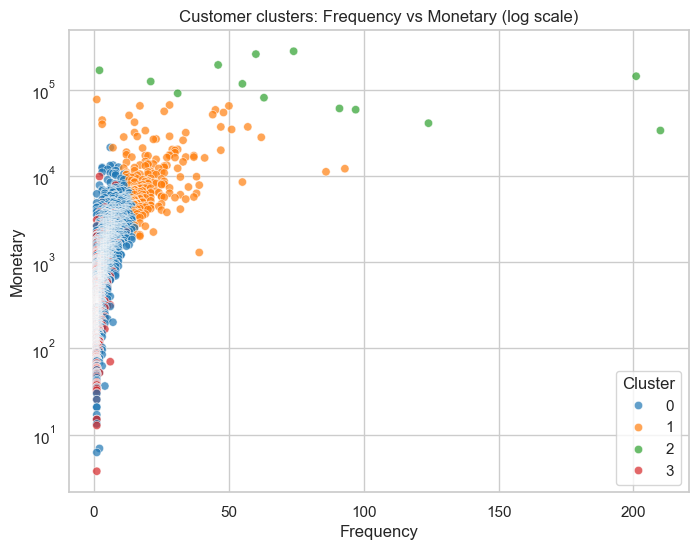

In [8]:
# Cell 8 - cluster sizes and summary
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)
display(cluster_summary)

# plot clusters (Monetary vs Frequency)
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm.reset_index(), x='Frequency', y='Monetary', hue='Cluster', palette='tab10', alpha=0.7)
plt.yscale('log')
plt.title('Customer clusters: Frequency vs Monetary (log scale)')
plt.savefig("clusters_freq_monetary.png", dpi=150)
plt.show()

This gives you an idea of which customers have which frequency/spending habits. As you can see, clusters 1 and 2 are the biggest drivers of business here as they tend to spend more frequently, as well as spend larger dollar amounts.

In [9]:
# Cell 9 - high-value label and distribution
threshold = rfm['Monetary'].quantile(0.75)
rfm['HighValue'] = (rfm['Monetary'] >= threshold).astype(int)
print("HighValue distribution:")
display(rfm['HighValue'].value_counts(normalize=True).to_frame('pct'))

HighValue distribution:


,pct
HighValue,
0,0.749942
1,0.250058


We see here that 25% of our customers are high value customers. We want to make sure to build a targeting strategy around them to incentivize repeat business with them in particular.

In [10]:
# Cell 10 - prepare features (RFM) and baseline classifier
X = rfm[['Recency','Frequency','Monetary']].copy()
y = rfm['HighValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print("Train/Test sizes:", X_train.shape, X_test.shape)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

t0 = time.time()
pipe.fit(X_train, y_train)
train_time = time.time() - t0

y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Logistic Regression baseline (train time {train_time:.3f}s):")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("\nConfusion Matrix:")
display(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Train/Test sizes: (3037, 3) (1302, 3)
Logistic Regression baseline (train time 0.006s):
Accuracy: 0.9616, Precision: 0.9894, Recall: 0.8558, F1: 0.9178

Confusion Matrix:


array([[973,   3],
       [ 47, 279]])


Classification Report:
              precision    recall  f1-score   support

           0     0.9539    0.9969    0.9749       976
           1     0.9894    0.8558    0.9178       326

    accuracy                         0.9616      1302
   macro avg     0.9716    0.9264    0.9464      1302
weighted avg     0.9628    0.9616    0.9606      1302



In [11]:
# Cell 11 - compare simple models (fast)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    'Logistic': pipe,
    'KNN': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

rows = []
for name, m in models.items():
    t0 = time.time()
    m.fit(X_train, y_train)
    t1 = time.time()
    rows.append({
        'Model': name,
        'Train Time (s)': round(t1 - t0, 3),
        'Train Acc': round(m.score(X_train, y_train), 4),
        'Test Acc': round(m.score(X_test, y_test), 4)
    })
results_df = pd.DataFrame(rows).sort_values('Test Acc', ascending=False).reset_index(drop=True)
display(results_df)
results_df.to_csv("baseline_model_comparison.csv", index=False)

,Model,Train Time (s),Train Acc,Test Acc
0,DecisionTree,0.002,1.0000,1.0000
1,KNN,0.002,0.9816,0.9670
2,Logistic,0.005,0.9625,0.9616


In [12]:
# Cell 12 - Save artifacts and short summary
rfm.to_csv("rfm_customers.csv")
rfm[['Cluster','Recency','Frequency','Monetary','HighValue']].head().to_csv("rfm_sample.csv", index=True)
print("Saved `rfm_customers.csv` and model comparison to working directory.")

# Quick textual summary (you can copy this into README)
summary = f"""
RFM computed for {rfm.shape[0]} customers. KMeans (k={k}) produced cluster sizes:
{rfm['Cluster'].value_counts().to_dict()}

The logistic regression baseline (predicting top-25% Monetary as HighValue) achieved:
Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}
"""
print(summary)

Saved `rfm_customers.csv` and model comparison to working directory.

RFM computed for 4339 customers. KMeans (k=4) produced cluster sizes:
{0: 3059, 3: 1063, 1: 204, 2: 13}

The logistic regression baseline (predicting top-25% Monetary as HighValue) achieved:
Accuracy: 0.9616, Precision: 0.9894, Recall: 0.8558, F1: 0.9178

